In [15]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold, PredefinedSplit
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np


Helper Functions:

In [2]:
def plot_side_by_side(img_1, img_2, title1="Original Image", title2="Processed Image"):
    """
    A function to plot two images side by side.
    """
    # if len(img_1.shape) == 3 or len(img_2.shape) == 3:
    #     img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
    #     img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].imshow(img_1, cmap='gray')
    axs[1].imshow(img_2, cmap='gray')

    axs[0].set_title(title1)
    axs[1].set_title(title2)


def get_coordinates(path):

    with open(path, 'r') as file:
        text = file.read()

    coordinates = []
    text = text.replace('\n', ',').replace(' ', ',').split(',')

    for i in text:
        if i == '':
            text.remove(i)

    for i in range(0, len(text), 2):
        coordinates.append((int(text[i]), int(text[i+1])))

    return coordinates


def annotate_img(img, coordinates):
    img_annotated = img.copy()

    for coord in coordinates:
        x, y = coord
        cv2.rectangle(img_annotated, (x, y), (x, y), (255, 255, 0), 2)

    return img_annotated


def clean_image(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(img_gray, 80, 255, cv2.THRESH_BINARY)
    binary = abs(255 - binary)

    kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
    kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))

    eroded_img = cv2.morphologyEx(binary, cv2.MORPH_ERODE, kernel2, iterations=2)
    morph_gradient = cv2.morphologyEx(eroded_img, cv2.MORPH_GRADIENT, kernel1, iterations=2)    

    return morph_gradient


def clean_image_2(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(img_gray, 80, 255, cv2.THRESH_BINARY)
    binary = abs(255 - binary)

    kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
    kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))

    opened_img = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel1, iterations=1)
    opened_img = cv2.morphologyEx(opened_img, cv2.MORPH_DILATE, kernel2, iterations=1)

    return opened_img


def find_label(features_data, coordinates):

    labels_data = []

    found_component = False
    coordinates_copy = coordinates.copy()

    for i in features_data:
        x1, y1, w, h, area, cX, cY = i
        
        for i in coordinates_copy:
            x, y = i
            if  (x1 <= x and x <= x1 + w) and (y1 <= y and y <= y1 + h):
                labels_data.append(1)
                found_component = True
                coordinates_copy.remove(i)
                break
        
        if not found_component:
            labels_data.append(0)

        found_component = False

    return labels_data

In [16]:
def calculate_iou_from_labels(y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()

        iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
        return iou


def perform_grid_search(X_train, y_train, X_test, y_test):
    pipeline_rf = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(random_state=42))
    ])

    param_grid_rf = {
        'classifier__n_estimators': [100, 200, 500, 1000],
        'classifier__max_depth': [None, 10, 20, 50, 100],
        'classifier__min_samples_split': [2, 5, 10, 20],
        'classifier__class_weight': ['balanced']
    }


    iou_scorer = make_scorer(calculate_iou_from_labels, greater_is_better=True)

    # Combine your X_train and X_val into one dataset
    X_combined = np.concatenate((X_train, X_test), axis=0)
    y_combined = np.concatenate((y_train, y_test), axis=0)

    # Define test_fold array: -1 means train, 0 means validation
    test_fold = [-1]*len(X_train) + [0]*len(X_test)

    # print(len(X_combined))
    # print(len(test_fold))

    ps = PredefinedSplit(test_fold=test_fold)

    grid_search_rf = GridSearchCV(
        pipeline_rf,
        param_grid_rf,
        scoring=iou_scorer,
        cv=ps,
        verbose=2,
        n_jobs=-1
    )

    grid_search_rf.fit(X_combined, y_combined)

    return grid_search_rf.best_params_, grid_search_rf.best_score_


def extract_shape_features(w, h, area):
    aspect_ratio = w / h
    compactness = area / (w * h)
    perimeter = 2 * (w + h)
    circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
    return [aspect_ratio, compactness, circularity]


def extract_hsv_histogram(cell_crop, bins=16):
    hsv = cv2.cvtColor(cell_crop, cv2.COLOR_RGB2HSV)
    chans = cv2.split(hsv)
    hist_features = []

    for chan in chans:
        hist = cv2.calcHist([chan], [0], None, [bins], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        hist_features.extend(hist)

    return np.array(hist_features)

def extract_rgb_histogram(cell_crop, bins=16):
    # Split image into R, G, B channels
    chans = cv2.split(cell_crop)
    hist_features = []

    for chan in chans:
        hist = cv2.calcHist([chan], [0], None, [bins], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        hist_features.extend(hist)

    return np.array(hist_features)


def bag_of_visual_words(kmeans, k, images, all_features):
    bovw_features = []
    average_colors = []
    local_features = []

    for i in range(len(images)):
        img = cv2.imread(images[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        features_data = all_features[i]

        for i, (x, y, w, h, area, cX, cY) in enumerate(features_data):
            crop = img[y:y+h, x:x+w]
            keypoints, descriptors = sift.detectAndCompute(crop, None)

            average_colors.append(np.mean(crop, axis=(0, 1)))
            local_features.append([w, h, area, *extract_shape_features(w, h, area)])
            
            if descriptors is not None:
                words = kmeans.predict(descriptors)
                hist, _ = np.histogram(words, bins=np.arange(k+1))  # (k,)
            else:
                hist = np.zeros(k)  # no keypoints detected

            bovw_features.append(hist)

    concatenated_features = np.concatenate((np.array(bovw_features), local_features, average_colors), axis=1)
    standardized_features = scaler.fit_transform(concatenated_features)

    return standardized_features


def get_features_and_labels(images, coordinates):
    descriptors_= []
    labels = []
    keypoints_ = []
    features = []

    for i in range(len(images)):
        img = cv2.imread(images[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cleaned_img = clean_image(img)
        coordinates_val = get_coordinates(coordinates[i])

        # plot_side_by_side(cleaned_img, annotate_img(cv2.cvtColor(cleaned_img, cv2.COLOR_GRAY2BGR), coordinates), title1="Cleaned Image", title2="Cleaned Image with Annotations")

        num_labels, labels_im, stats, centroids = cv2.connectedComponentsWithStats(cleaned_img, connectivity=8)

        features_data_test = []

        for i in range(0, num_labels):
            if i != 0:
                x = stats[i, cv2.CC_STAT_LEFT]
                y = stats[i, cv2.CC_STAT_TOP]
                w = stats[i, cv2.CC_STAT_WIDTH]
                h = stats[i, cv2.CC_STAT_HEIGHT]
                area = stats[i, cv2.CC_STAT_AREA]
                cX, cY = centroids[i]

                features_data_test.append([x, y, w, h, area, cX, cY])

        labels_data_test = find_label(features_data_test, coordinates_val)

        labels.append(labels_data_test)

        # print(len(features_data_test), len(labels_data_test))

        for i in features_data_test:
            x1, y1, w, h, area, cX, cY = i
            cell_crop = img[y1:y1+h, x1:x1+w]

            cell_crop_gray = cv2.cvtColor(cell_crop, cv2.COLOR_RGB2GRAY)

            keypoints, descriptors = sift.detectAndCompute(cell_crop_gray, None)

            descriptors_.append(descriptors)
            keypoints_.append(keypoints)

        features.append(features_data_test)

    return features, labels, descriptors_


sift = cv2.SIFT_create()
scaler = StandardScaler()

Reading the first training image. I was using Visual Studio Code, if you are using Google Colab, you should adjust the path to images and csv files

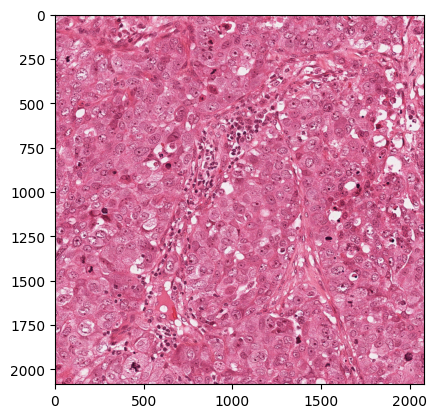

In [4]:
img = cv2.imread("scanner_A/A01_v2/A01_00.bmp")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)

coordinates = get_coordinates("scanner_A/A01_v2/A01_00.csv")

Applying morphological operators to set cells apart from the background

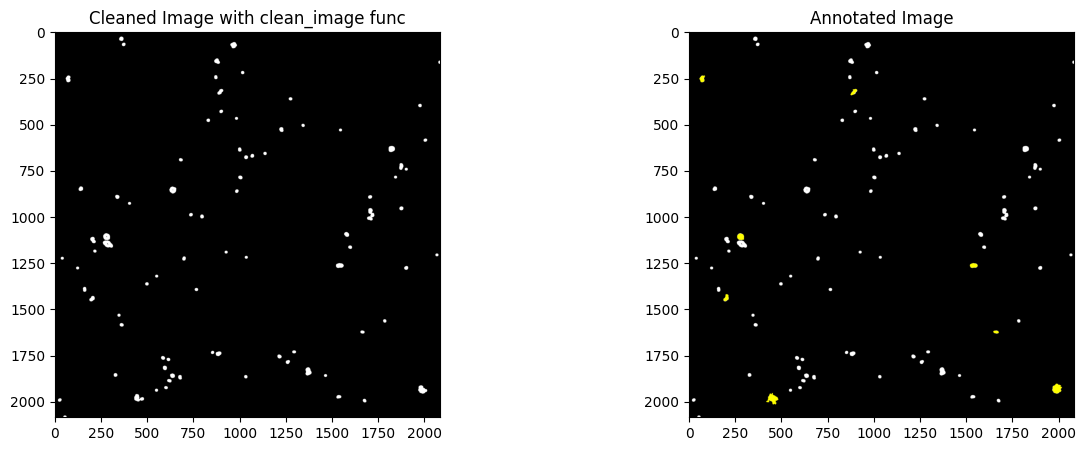

In [5]:
cleaned_1 = clean_image(img)

plot_side_by_side(cleaned_1, annotate_img(cv2.cvtColor(cleaned_1, cv2.COLOR_GRAY2BGR), coordinates), title1="Cleaned Image with clean_image func", title2="Annotated Image")

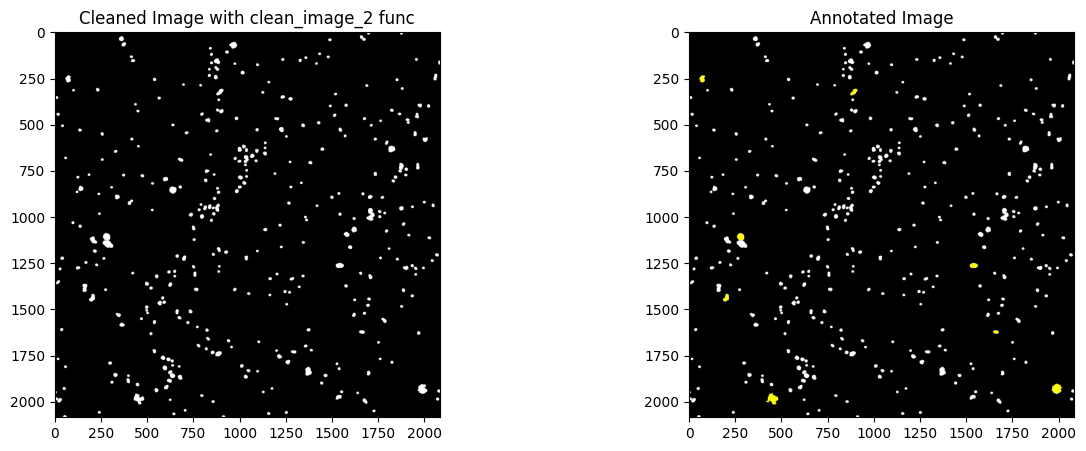

In [6]:
cleaned_2 = clean_image_2(img)

plot_side_by_side(cleaned_2, annotate_img(cv2.cvtColor(cleaned_2, cv2.COLOR_GRAY2BGR), coordinates), title1="Cleaned Image with clean_image_2 func", title2="Annotated Image")

Extracting the cells by extracting connected components

Number of cells detected (excluding background): 84


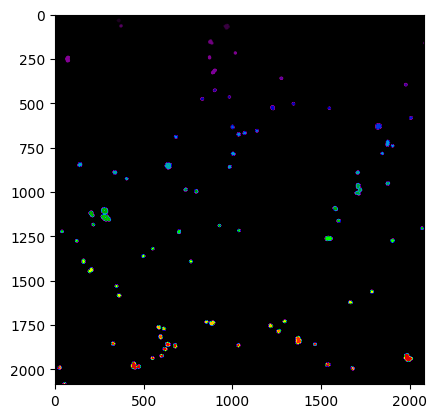

In [7]:
num_labels, labels_im, stats, centroids = cv2.connectedComponentsWithStats(cleaned_1, connectivity=8)

print(f"Number of cells detected (excluding background): {num_labels - 1}")

plt.imshow(labels_im, cmap='nipy_spectral')

84
0


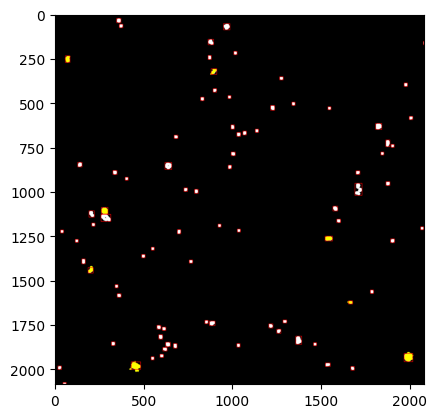

In [8]:
cleaned_annotations = annotate_img(cv2.cvtColor(cleaned_1, cv2.COLOR_GRAY2BGR), coordinates)

cleaned_annotations_copy = cleaned_annotations.copy()

features_data = []
labels_data = []

for i in range(0, num_labels):
    if i != 0:
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        cX, cY = centroids[i]

        features_data.append([x, y, w, h, area, cX, cY])

        cleaned_annotations_copy = cv2.rectangle(cleaned_annotations_copy, (x, y), (x+w, y+h), (255, 0, 0), 2)


plt.imshow(cleaned_annotations_copy)
print(len(features_data))
print(len(labels_data))


In [9]:
training_images = ["scanner_A/A01_v2/A01_00.bmp", 
                   "scanner_A/A01_v2/A01_01.bmp", 
                   "scanner_A/A01_v2/A01_02.bmp", 
                   "scanner_A/A01_v2/A01_03.bmp", 
                   "scanner_A/A01_v2/A01_05.bmp",  
                   "scanner_A/A01_v2/A01_07.bmp", 
                   "scanner_A/A01_v2/A01_08.bmp",

                   "scanner_A/A03_v2/A03_02.bmp",
                   "scanner_A/A03_v2/A03_03.bmp",
                   "scanner_A/A03_v2/A03_05.bmp",
                   "scanner_A/A03_v2/A03_06.bmp",
                   "scanner_A/A03_v2/A03_07.bmp",
                   "scanner_A/A03_v2/A03_08.bmp",
                   "scanner_A/A03_v2/A03_09.bmp",
                   
                   "scanner_A/A04_v2/A04_00.bmp",
                   "scanner_A/A04_v2/A04_01.bmp",
                   "scanner_A/A04_v2/A04_02.bmp",
                   "scanner_A/A04_v2/A04_04.bmp",
                   "scanner_A/A04_v2/A04_05.bmp",
                   "scanner_A/A04_v2/A04_06.bmp",
                   "scanner_A/A04_v2/A04_08.bmp"]

training_coordinates = ["scanner_A/A01_v2/A01_00.csv", 
                        "scanner_A/A01_v2/A01_01.csv", 
                        "scanner_A/A01_v2/A01_02.csv", 
                        "scanner_A/A01_v2/A01_03.csv", 
                        "scanner_A/A01_v2/A01_05.csv", 
                        "scanner_A/A01_v2/A01_07.csv", 
                        "scanner_A/A01_v2/A01_08.csv",
                        
                        "scanner_A/A03_v2/A03_02.csv",
                        "scanner_A/A03_v2/A03_03.csv",
                        "scanner_A/A03_v2/A03_05.csv",
                        "scanner_A/A03_v2/A03_06.csv",
                        "scanner_A/A03_v2/A03_07.csv",
                        "scanner_A/A03_v2/A03_08.csv",
                        "scanner_A/A03_v2/A03_09.csv",
                        
                        "scanner_A/A04_v2/A04_00.csv",
                        "scanner_A/A04_v2/A04_01.csv",
                        "scanner_A/A04_v2/A04_02.csv",
                        "scanner_A/A04_v2/A04_04.csv",
                        "scanner_A/A04_v2/A04_05.csv",
                        "scanner_A/A04_v2/A04_06.csv",
                        "scanner_A/A04_v2/A04_08.csv"]

print(len(training_images), len(training_coordinates)) 

21 21


Outputting all the training images to see how well "clean_image" functions sets the cells apart

C:\Users\Adil\AppData\Local\Temp\ipykernel_22328\2438069258.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 2, figsize=(15, 5))


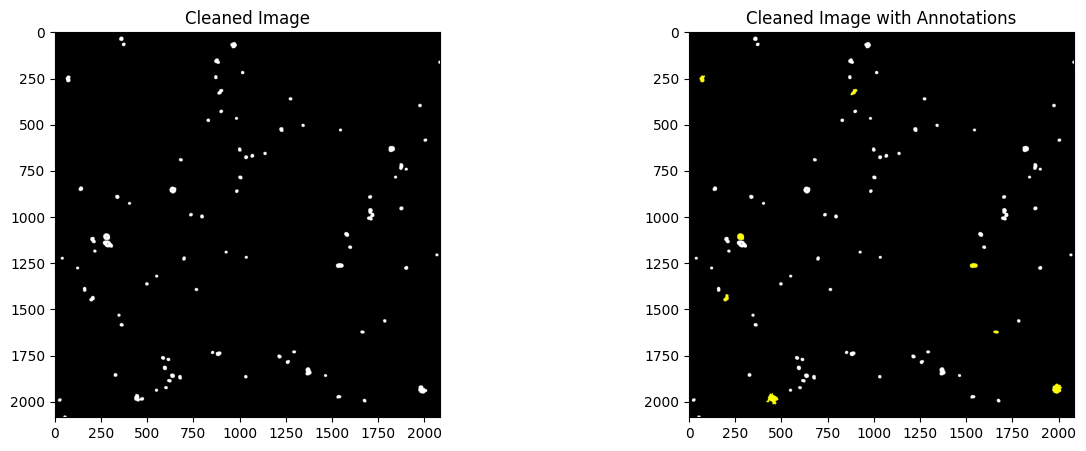

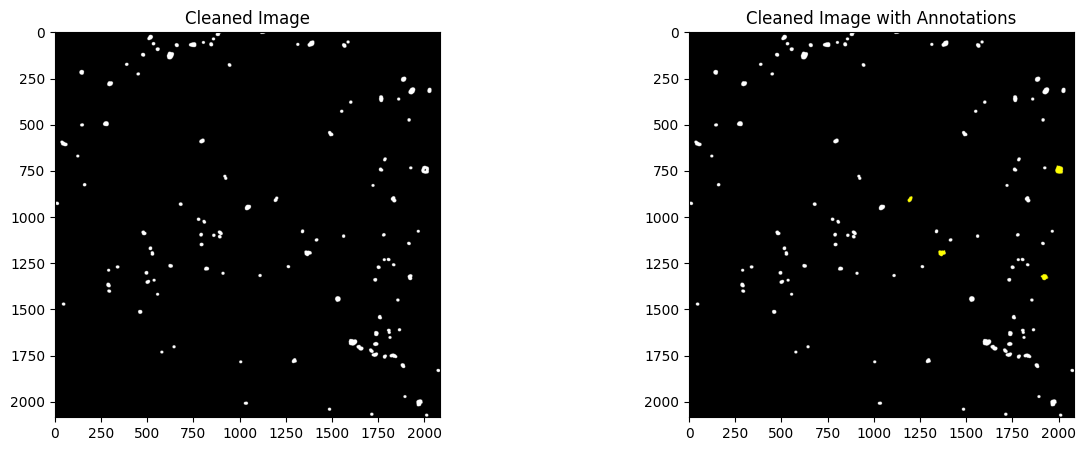

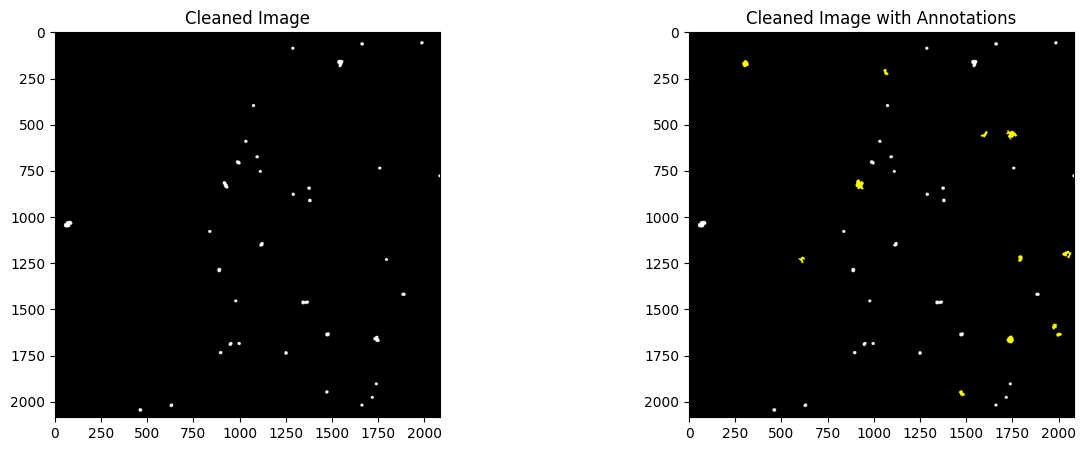

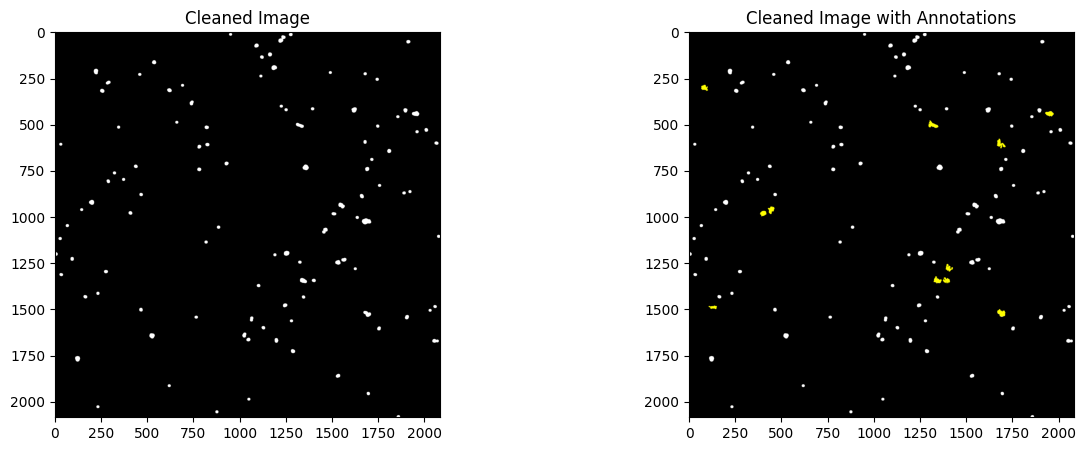

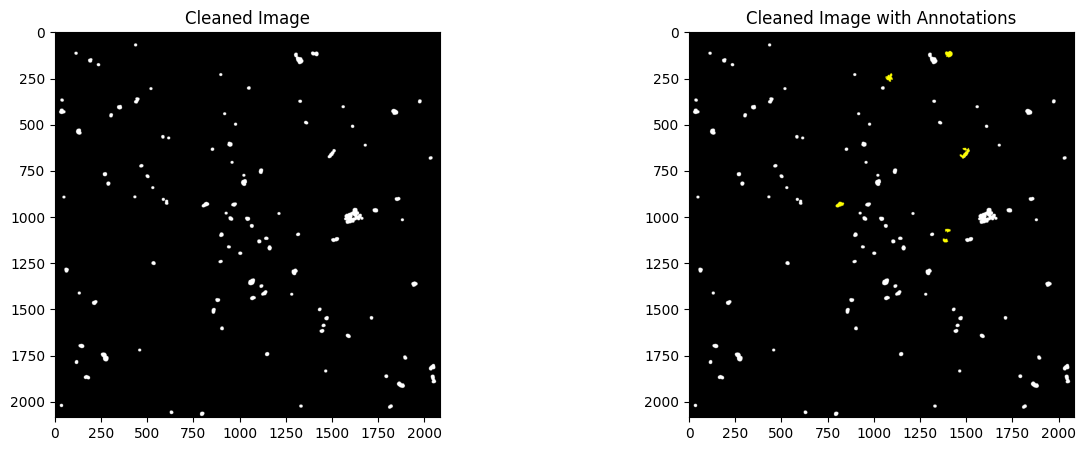

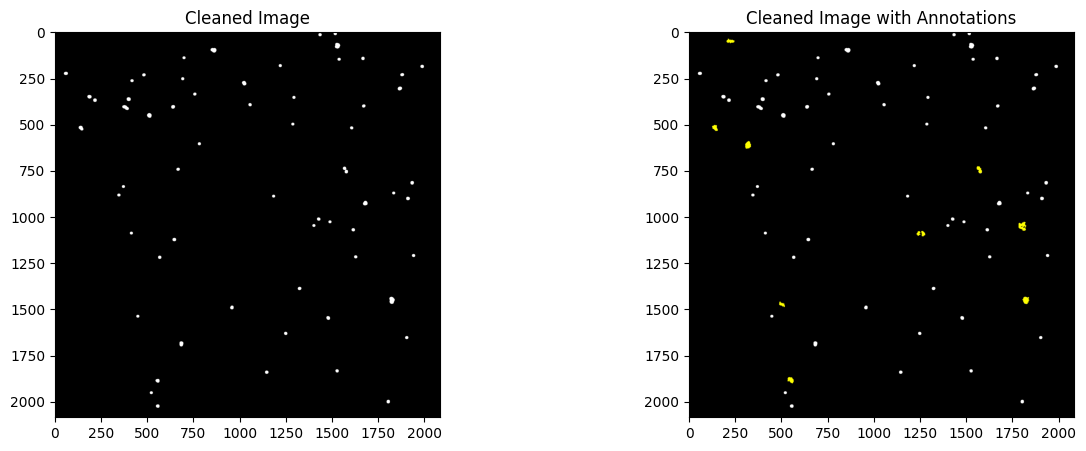

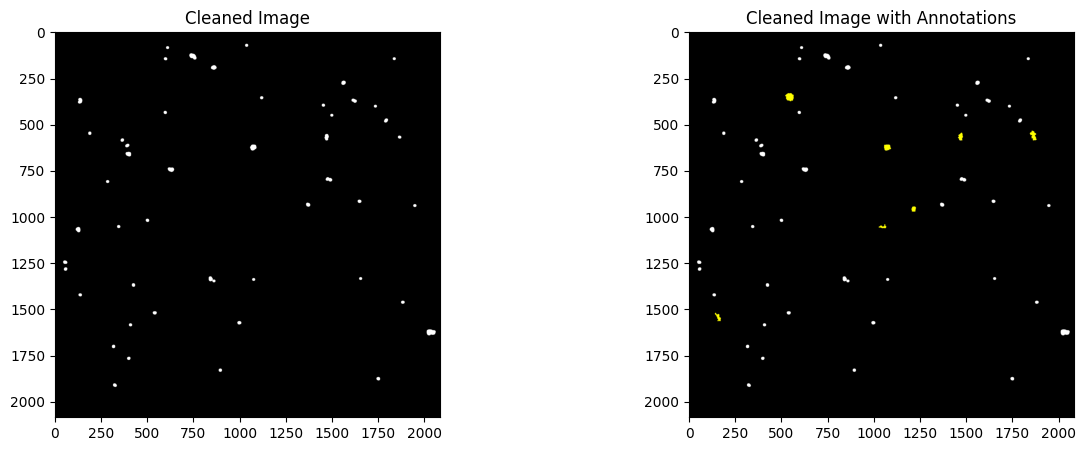

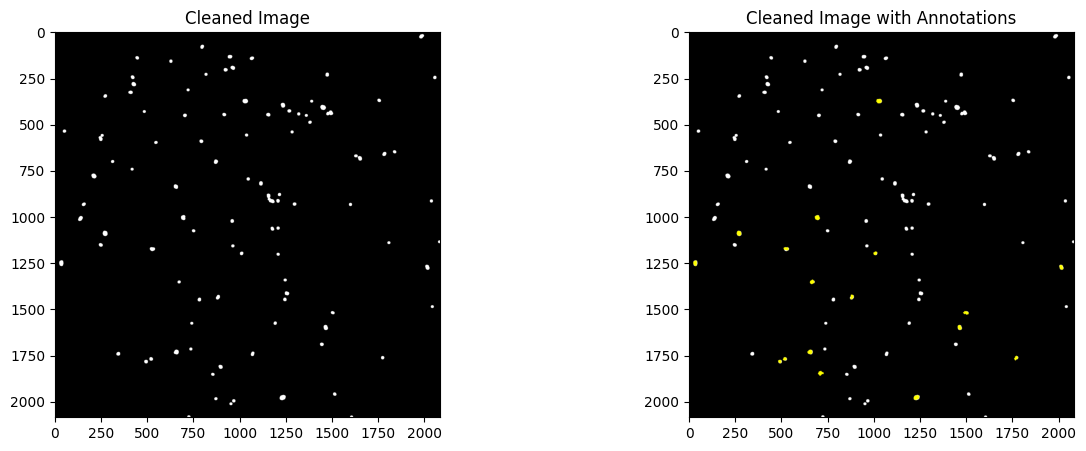

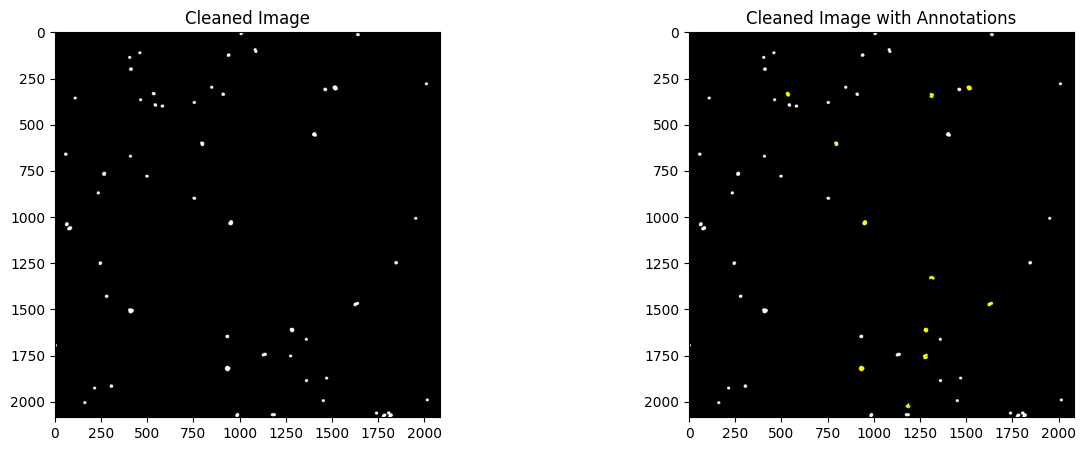

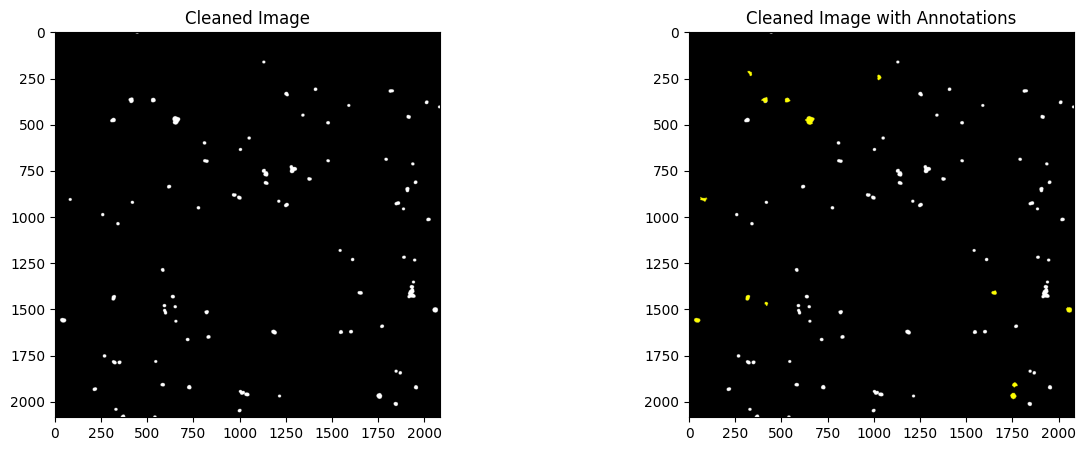

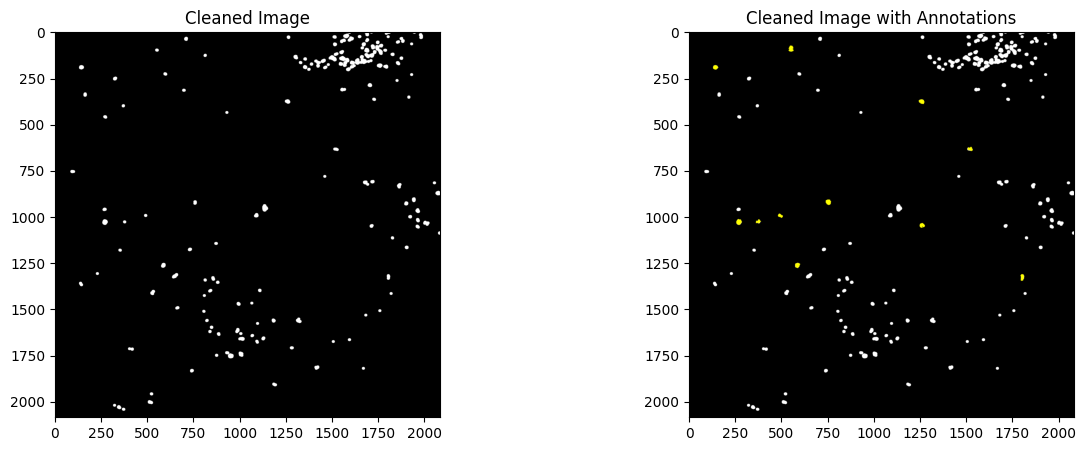

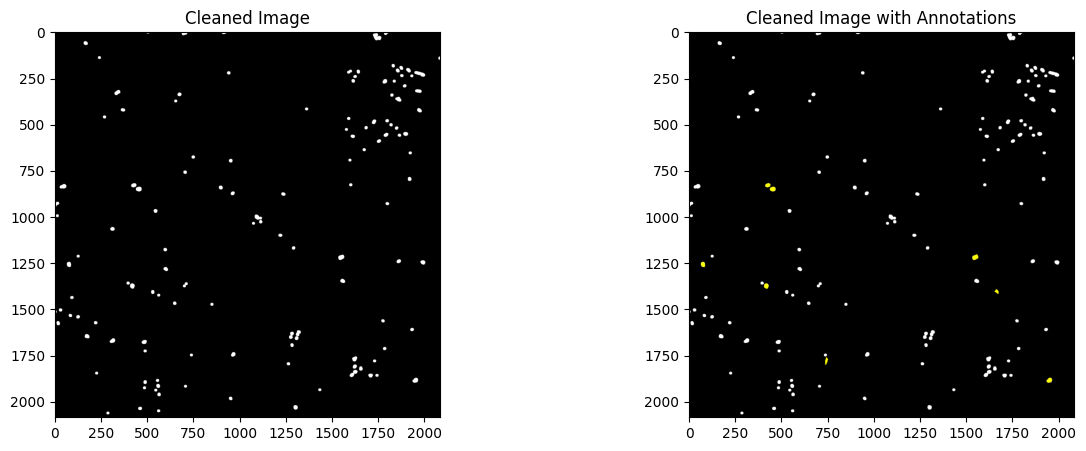

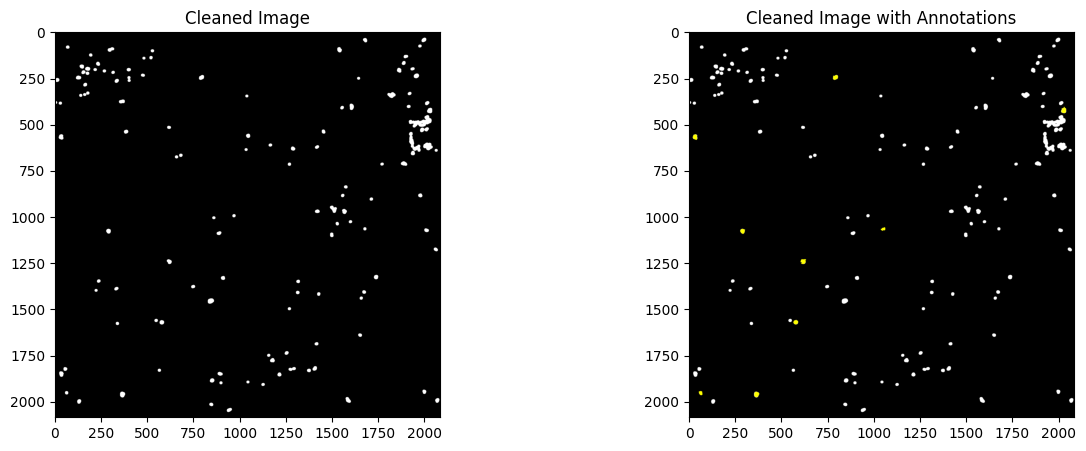

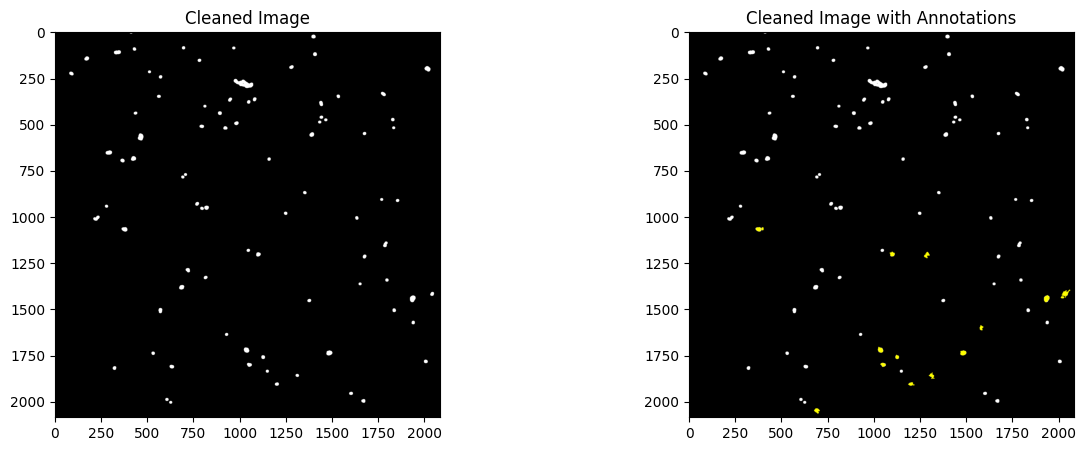

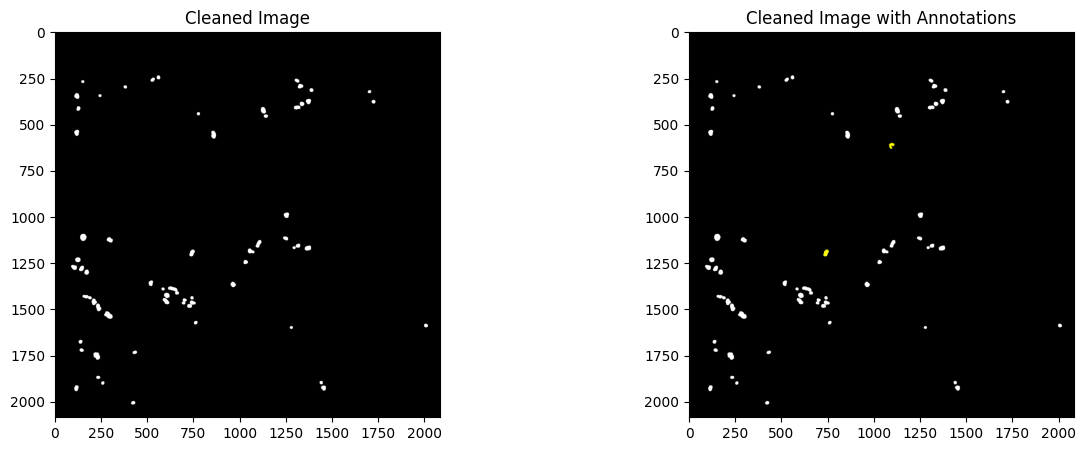

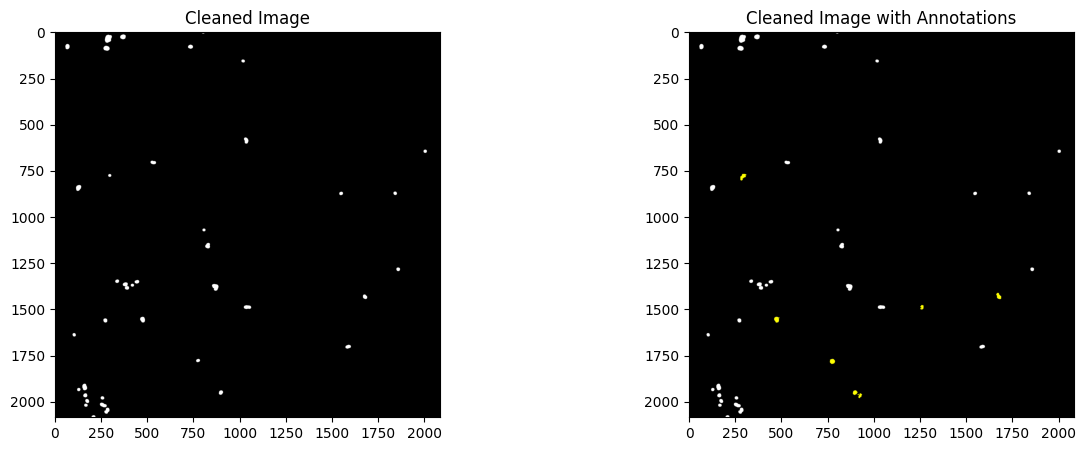

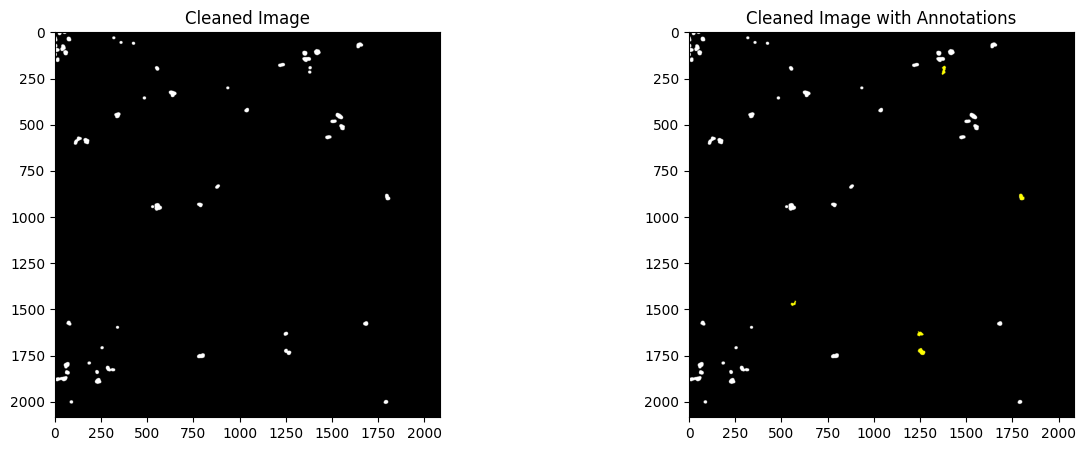

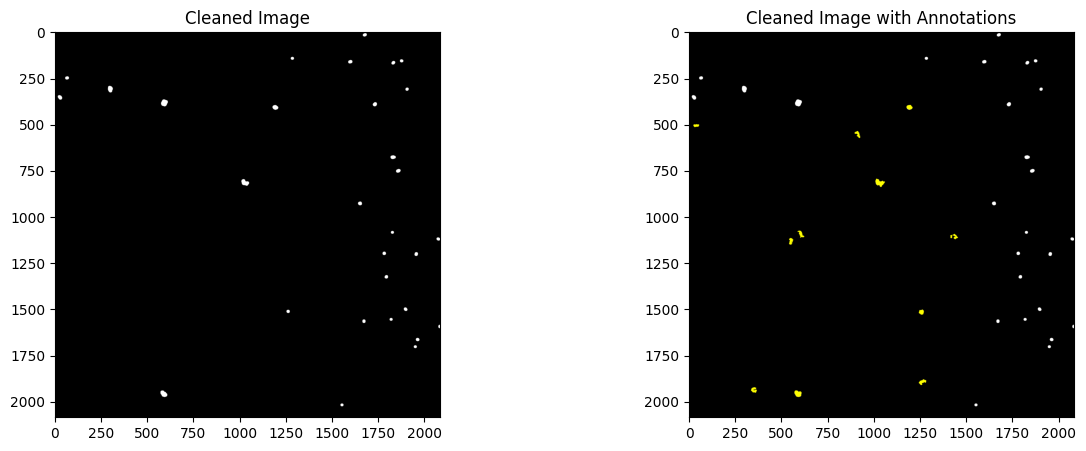

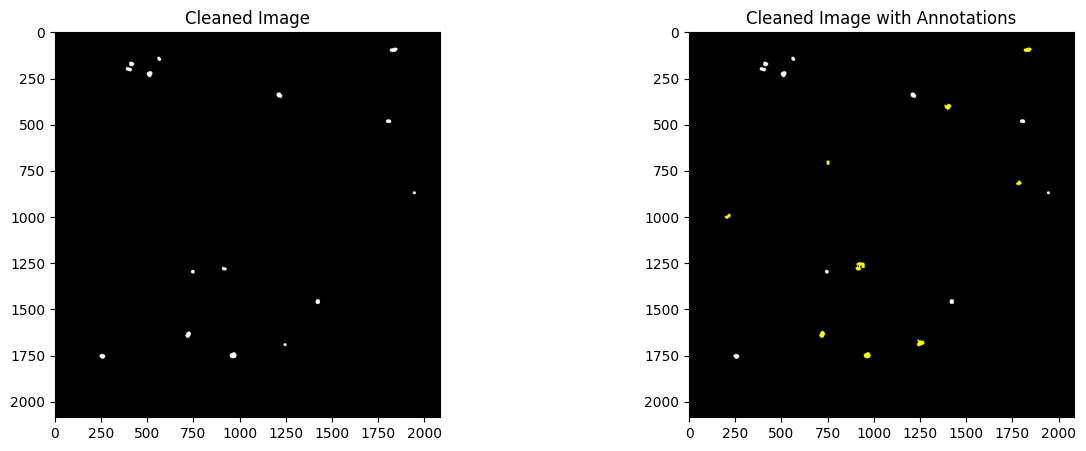

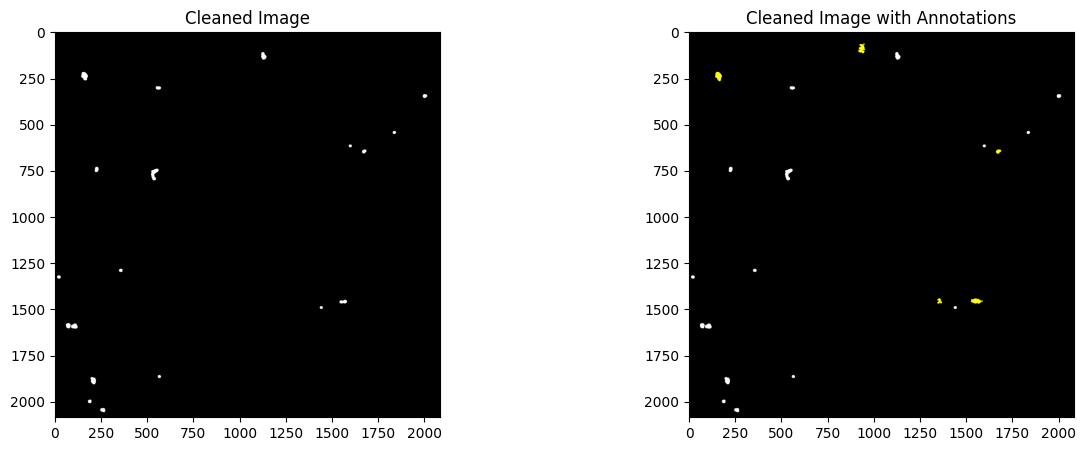

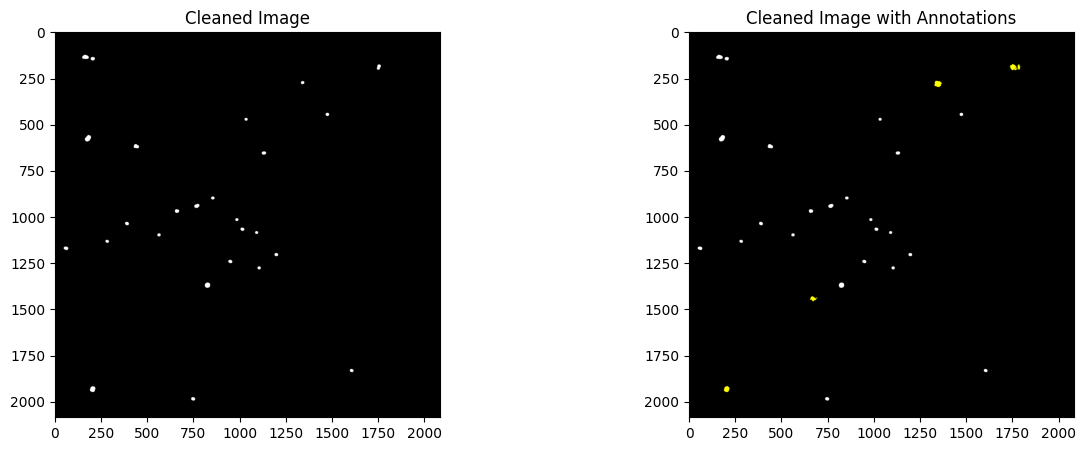

In [10]:
for i in range(len(training_images)):
    img = cv2.imread(training_images[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cleaned_img = clean_image(img)
    plot_side_by_side(cleaned_img, annotate_img(cv2.cvtColor(cleaned_img, cv2.COLOR_GRAY2BGR), get_coordinates(training_coordinates[i])), title1="Cleaned Image", title2="Cleaned Image with Annotations")
    

We can clearly see that our function does not accurately identifies all the mitosis cells

Making training dataset with 30 visual words + 9 local features (width, height, area, average red, green, blue channels,
aspect ratio, compactness, and circularity)

In [11]:
train_features, train_labels, train_descriptors = get_features_and_labels(training_images, training_coordinates)

all_desc_flat = np.vstack([desc for desc in train_descriptors if desc is not None])

k = 30  # number of visual words
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(all_desc_flat)

X_train = bag_of_visual_words(kmeans, k, training_images, train_features)
y_train = np.concatenate(train_labels)
   
print(len(X_train), len(y_train))

1497 1497


In [12]:
validation_images = ["scanner_A/A02_v2/A02_02.bmp",
                     "scanner_A/A02_v2/A02_04.bmp",
                     "scanner_A/A02_v2/A02_05.bmp",
                     "scanner_A/A02_v2/A02_06.bmp",
                     "scanner_A/A02_v2/A02_08.bmp",
                     "scanner_A/A02_v2/A02_09.bmp"]

validation_coordinates = ["scanner_A/A02_v2/A02_02.csv",
                            "scanner_A/A02_v2/A02_04.csv",
                            "scanner_A/A02_v2/A02_05.csv",
                            "scanner_A/A02_v2/A02_06.csv",
                            "scanner_A/A02_v2/A02_08.csv",
                            "scanner_A/A02_v2/A02_09.csv"]

Making Validation dataset with 30 visual words + 9 local features (width, height, area, average red, green, blue channels,
aspect ratio, compactness, and circularity)

In [13]:
val_features, val_labels, val_descriptors = get_features_and_labels(validation_images, validation_coordinates)

X_validation = bag_of_visual_words(kmeans, k, validation_images, val_features)
y_validation = np.concatenate(val_labels)

print(len(X_validation), len(y_validation))

1756 1756


Performing Grid Search on these datasets

In [17]:
best_params, best_score = perform_grid_search(X_train, y_train, X_validation, y_validation)
print(f"Best parameters: {best_params}")
print(f"Best IoU: {best_score}")
print("--------------------------------------------------")

Fitting 1 folds for each of 80 candidates, totalling 80 fits
Best parameters: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best IoU: 0.1724137931034483
--------------------------------------------------


We did Grid Search on random forest model with 30 visual words. Let's now try to grid search number of visual words that gives us highest IoU and F1-score 

This took approximately 5 minutes on my laptop, if you do not have time you can skip to the moment where I am testing the hypertuned model on testing dataset

In [18]:
visual_words = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for i in visual_words:

    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(all_desc_flat)

    X_train = bag_of_visual_words(kmeans, i, training_images, train_features)
    X_validation = bag_of_visual_words(kmeans, i, validation_images, val_features)


    best_params, best_score = perform_grid_search(X_train, y_train, X_validation, y_validation)

    print(f"Number of visual words: {i}")
    print(f"Best parameters: {best_params}")
    print(f"Best IoU: {best_score}")
    print("--------------------------------------------------")

    

Fitting 1 folds for each of 80 candidates, totalling 80 fits
Number of visual words: 10
Best parameters: {'classifier__class_weight': 'balanced', 'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best IoU: 0.18604651162790697
--------------------------------------------------
Fitting 1 folds for each of 80 candidates, totalling 80 fits
Number of visual words: 20
Best parameters: {'classifier__class_weight': 'balanced', 'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 500}
Best IoU: 0.20930232558139536
--------------------------------------------------
Fitting 1 folds for each of 80 candidates, totalling 80 fits
Number of visual words: 30
Best parameters: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best IoU: 0.1724137931034483
--------------------------------------------------
Fitting 1 folds for ea

Best IoU score that we could get is 0.257 with number of visual words of 80 and these parameters for Random Forest model:

Best parameters: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 20, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}


Let's analyze this particular case

In [23]:
kmeans = KMeans(n_clusters=80, random_state=42)
kmeans.fit(all_desc_flat)

X_train = bag_of_visual_words(kmeans, 80, training_images, train_features)
X_validation = bag_of_visual_words(kmeans, 80, validation_images, val_features)

validation_rf = RandomForestClassifier(class_weight='balanced', max_depth=20, min_samples_split=10, n_estimators=200, random_state=42)
validation_rf.fit(X_train, y_train)

predictions_rf = validation_rf.predict(X_validation)

print("Accuracy:", accuracy_score(predictions_rf, y_validation))
print(confusion_matrix(predictions_rf, y_validation))
print(classification_report(predictions_rf, y_validation))
print("IoU:", calculate_iou_from_labels(predictions_rf, y_validation))


Accuracy: 0.9851936218678815
[[1721   12]
 [  14    9]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1733
           1       0.43      0.39      0.41        23

    accuracy                           0.99      1756
   macro avg       0.71      0.69      0.70      1756
weighted avg       0.98      0.99      0.98      1756

IoU: 0.2571428571428571


We can also observe that f1-score is 0.41 for 1's


Now I will perform the same Grid Search for XGboost model

This might take 12-15 minutes, I am not using XGboost model in the end, you may decide not to run following 2 cells and nothing will break before testing on test dataset

In [26]:
from xgboost import XGBClassifier


def perform_grid_search_xgboost(X_train, y_train, X_test, y_test):
    pipeline_xgb = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', XGBClassifier(random_state=42))
    ])

    param_grid_xgb = {
        'classifier__n_estimators': [100, 200, 500, 1000],
        'classifier__max_depth': [None, 10, 20, 50, 100],
        'classifier__min_child_weight': [1, 3, 5],
        'classifier__subsample': [0.8, 1.0],
        'classifier__colsample_bytree': [0.8, 1.0],
        'classifier__learning_rate': [0.1, 0.01, 0.001]
    }

    iou_scorer = make_scorer(calculate_iou_from_labels, greater_is_better=True)

    X_combined = np.concatenate((X_train, X_test), axis=0)
    y_combined = np.concatenate((y_train, y_test), axis=0)

    test_fold = [-1]*len(X_train) + [0]*len(X_test)

    ps = PredefinedSplit(test_fold=test_fold)

    grid_search_xgb = GridSearchCV(
        pipeline_xgb,
        param_grid_xgb,
        scoring=iou_scorer,
        cv=ps,
        verbose=2,
        n_jobs=-1
    )

    grid_search_xgb.fit(X_combined, y_combined)

    return grid_search_xgb.best_params_, grid_search_xgb.best_score_


In [27]:
for i in visual_words:

    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(all_desc_flat)

    X_train = bag_of_visual_words(kmeans, i, training_images, train_features)
    val_x = bag_of_visual_words(kmeans, i, validation_images, val_features)


    best_params, best_score = perform_grid_search_xgboost(X_train, y_train, val_x, y_validation)

    print(f"Number of visual words: {i}")
    print(f"Best parameters: {best_params}")
    print(f"Best IoU: {best_score}")
    print("--------------------------------------------------")

Fitting 1 folds for each of 720 candidates, totalling 720 fits
Number of visual words: 10
Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__min_child_weight': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 1.0}
Best IoU: 0.18604651162790697
--------------------------------------------------
Fitting 1 folds for each of 720 candidates, totalling 720 fits
Number of visual words: 20
Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.001, 'classifier__max_depth': None, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 1000, 'classifier__subsample': 1.0}
Best IoU: 0.18518518518518517
--------------------------------------------------
Fitting 1 folds for each of 720 candidates, totalling 720 fits
Number of visual words: 30
Best parameters: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.01, 'classifier__max_depth': None, 'classifie

As we can observe XGBoost model performs worse than Random Forest

Now when we know the best parameters and the features, let's run the model on the test data

In [28]:
test_images = ["scanner_A/A00_v2/A00_01.bmp",
               "scanner_A/A00_v2/A00_02.bmp",
               "scanner_A/A00_v2/A00_03.bmp",
               "scanner_A/A00_v2/A00_04.bmp",
                "scanner_A/A00_v2/A00_05.bmp",
                "scanner_A/A00_v2/A00_06.bmp",
                "scanner_A/A00_v2/A00_07.bmp",
                "scanner_A/A00_v2/A00_09.bmp",]

test_coordinates = ["scanner_A/A00_v2/A00_01.csv",
                    "scanner_A/A00_v2/A00_02.csv",
                    "scanner_A/A00_v2/A00_03.csv",
                    "scanner_A/A00_v2/A00_04.csv",
                    "scanner_A/A00_v2/A00_05.csv",
                    "scanner_A/A00_v2/A00_06.csv",
                    "scanner_A/A00_v2/A00_07.csv",
                    "scanner_A/A00_v2/A00_09.csv"]

In [31]:
test_features, test_labels, test_descriptors = get_features_and_labels(test_images, test_coordinates)
test_x = bag_of_visual_words(kmeans, 80, test_images, test_features)
test_y = np.concatenate(test_labels)
print(len(test_x), len(test_y)) 

1737 1737


However, I can't understand why, but if you run Grid Search on XGBoost, the IoU here gets to 0.296. However, if you don't run it, it drops to 0.17( 

In [32]:
test_predictions = validation_rf.predict(test_x)

print("Accuracy:", accuracy_score(test_predictions, test_y))
print(confusion_matrix(test_predictions, test_y))
print(classification_report(test_predictions, test_y))
print("IoU:", calculate_iou_from_labels(test_predictions, test_y))

Accuracy: 0.9890616004605642
[[1710   13]
 [   6    8]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1723
           1       0.38      0.57      0.46        14

    accuracy                           0.99      1737
   macro avg       0.69      0.78      0.73      1737
weighted avg       0.99      0.99      0.99      1737

IoU: 0.2962962962962963
